# Домашнее задание 6 (20 pts)

Рассмотрим классическую модель для построения рекомендательных систем, основанную на матричной факторизации матрицы "item-user" $A$, которая содержит известные рейтинги продуктов от пользователей:

$$ \min_{P, Q} \sum_{(i, u) \in \mathcal{A}} (a_{ui} - \langle p_u, q_i \rangle)^2 + \frac{\lambda}{2}\left(\|P\|_F^2 + \|Q\|_F^2\right), \quad \lambda > 0, $$

где $\mathcal{A}$ множество пар пользователей и продуктов, рейтинги которых известны, а матрицы $P \in \mathbb{R}^{M \times d}$ и $Q \in \mathbb{R}^{N \times d}$ содержат вложения пользователей и продуктов в $d$-мерное пространство. Зафиксируйте $d$ достаточно большим для получения приемлемого качества, но учтите затраты по памяти.
Вам предлагается проанализировать эффективность различных методов решения этой задачи для данных с рейтингами книг, скачать которые можно [отсюда](https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset?select=Ratings.csv).
Для отслеживания эффекта переобучения разделите пользователей и продукты на обучающую и тестовую выборку. Способ разбиения остаётся на ваше усмотрение. Главное, чтобы он был разумен и отражал основную цель.

Для оценки эффективности нужно использовать следующие метрики:

1) значение целевой функции на обучающей и тестовой выборке

2) precision@k для небольшого $k$ по аналогии с задачей классификации

- Индекс рекомендуемого продукта генерируется сортировкой оценок релевантности $Qp_u$ для пользователя с индексом $u$ и исключением уже оценённых продуктов.
- Обратите внимание, что матрица $A$ разрежена и требует аккуратного обращения со своими элементами, чтобы не столкнуться с нехваткой памяти. Особенно это касается процедуры вычисления градиентов. Не забывайте об эффективности приводимых реализаций!

Поскольку целевая функция представляет из себя сумму функций каждая из которых зависит от своего индекса, то имеет смысл попробовать использовать стохатическую оценку градиента в методах первого порядка. Однако задача не является выпуклой, поэтому можно по-разному обновлять параметры $P$ и $Q$. Например, сравните, какая из следующих стратегий лучше

1) $P$ и $Q$ объединяются в один длинный вектор и обновляются одновренно одним из методов

2) попеременная оптимизация $P$ и $Q$ каким-то градиентным методов, то есть $P$ фиксирована и обновляется $Q$ сколько-то итераций, возможно до сходимости, и далее наоборот обновляется $P$ при фиксированной новой $Q$ с предыдущей итерации.

Сравните методы SGD, SGD Momentum, Adam и [Adan](https://github.com/sail-sg/Adan).

Возможно, для разных стратегий будут лучше работать разные методы. Приведите графики сходимости и обсуждение полученных результатов.

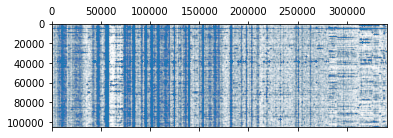

In [1]:
from scipy.sparse import csr_matrix, coo_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

data = pd.read_csv('archive/Ratings.csv')
lecols = LabelEncoder()
lerows = LabelEncoder()
ratings = data['Book-Rating'].values
row = lerows.fit_transform(data['User-ID'].values)
col = lecols.fit_transform(data['ISBN'].values)
numrows = data['User-ID'].nunique()
numcols = data['ISBN'].nunique()

A = coo_matrix((ratings, (row, col)), shape=(numrows, numcols)).tocsr()
plt.spy(A, markersize=0.01);

видно, что есть как супер популярные бестселлеры, так и никому ненужные мемуары. очевидно, раз наш подход опирается только на рейтинг, а не описание книг, то мы можем и должны удалить все книги у которых не выставлен рейтинг, а так же пользователей, которые размечали < 2 книг, тк по ним мы попросту не соберем никакую статистику и сделаем все только шумнее.

In [2]:
bookcounts = data.groupby('ISBN')['Book-Rating'].apply(lambda x: x[x > 0].count())
print(f'бесполезные книги: {(bookcounts < 2).sum()/len(bookcounts)*100:.0f}%')

бесполезные книги: 83%


In [3]:
usercounts = data[data['ISBN'].isin(bookcounts[bookcounts>=2].index)].\
  groupby('User-ID')['Book-Rating'].apply(lambda x: x[x > 0].count())
print(f'бесполезные люди: {(usercounts < 2).sum()/len(usercounts)*100:.0f}%')

бесполезные люди: 68%


In [4]:
data = data[data['ISBN'].isin(bookcounts[bookcounts>=2].index) & data['User-ID'].isin(usercounts[usercounts>=2].index)]
bookcounts = data.groupby('ISBN')['Book-Rating'].apply(lambda x: x[x > 0].count())
data = data[data['ISBN'].isin(bookcounts[bookcounts>=1].index)]

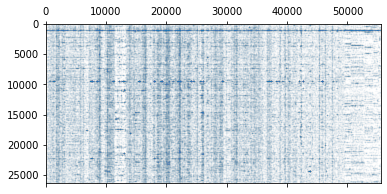

In [5]:
lecols = LabelEncoder()
lerows = LabelEncoder()
ratings = data['Book-Rating'].values
row = lerows.fit_transform(data['User-ID'].values)
col = lecols.fit_transform(data['ISBN'].values)
numrows = data['User-ID'].nunique()
numcols = data['ISBN'].nunique()

A = coo_matrix((ratings, (row, col)), shape=(numrows, numcols)).tocsr()
plt.spy(A, markersize=0.01);

картинка выглядит сильно приятнее ngl. разобьем train-test:

p.s. живые пользователи образуют time-series задачу при предсказании рекомендации.\
отсутствие времени оценки товара здесь может все испортить, а мы так и не поймем что не так

In [6]:
# split train/test such that for each user we have at least 1 ratings and train on 80% of the data:
data['user_book'] = data['User-ID'].astype(str) + '_' + data['ISBN'].astype(str)
data.set_index('user_book', inplace=True)

def _split(df, test_size=0.2):
  nonzero = df['Book-Rating']!=0
  test = np.random.choice(
    df[nonzero].index, 
    max(1, int(sum(nonzero)*test_size)),
    replace=False
    )  
  df.loc[test, 'isTrain'] = False
  df.loc[df.index.difference(test), 'isTrain'] = True
  return df

np.random.seed(42)
data['isTrain'] = data.groupby('User-ID').apply(_split).reset_index().set_index('user_book')['isTrain']

data.head()

,User-ID,ISBN,Book-Rating,isTrain
user_book,,,,
276747_0060517794,276747,0060517794,9,False
276747_0451192001,276747,0451192001,0,True
276747_0609801279,276747,0609801279,0,True
276747_0671537458,276747,0671537458,9,True
276747_0679776818,276747,0679776818,8,True


In [7]:
lecols = LabelEncoder()
lerows = LabelEncoder()
train_ratings = data['Book-Rating'].values * data['isTrain'].values.astype(int)
test_ratings  = data['Book-Rating'].values
row = lerows.fit_transform(data['User-ID'].values)
col = lecols.fit_transform(data['ISBN'].values)
numrows = data['User-ID'].nunique()
numcols = data['ISBN'].nunique()

Atrain = coo_matrix((train_ratings, (row, col)), shape=(numrows, numcols)).tocsr()
Atest  = coo_matrix((test_ratings,  (row, col)), shape=(numrows, numcols)).tocsr()

In [10]:
# уничтожим улики, чтобы ядро выжило
import gc
gc.collect()

del A, data, bookcounts, usercounts

- - - 

loss и цикл с град спуском

In [8]:
from IPython.display import display, clear_output
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline

def loss(A, P, Q, L):
  '''
  эта лосс функция видоизменена: вместо сумм квадратов считается их среднее,
  в ином случае (без нормализации) компьютер не справляется посчитать ни одну эпоху.
  '''
  nr, nc = A.get_shape()
  d = P.shape[1]
  diff  = torch.from_numpy(A.toarray()) - P@Q.T
  diff2sum = (diff*diff).sum() / nr / nc
  L2 = (P*P).sum() * L/2 / nr / d + (Q*Q).sum() * L/2 / nc / d
  return diff2sum + L2
  
def optimize_loss(A, P, Q, L, loss, optimizer, batch_sizes, num_epochs=1):
  np.random.seed(42)
  nrows, ncols = A.get_shape()
  row_batch_size, col_batch_size = batch_sizes
  n_row_batches = nrows // row_batch_size
  n_col_batches = ncols // col_batch_size
  
  # не понял как это сделать с Dataset, поэтому руками:
  row_batches = np.array_split(
    np.random.permutation(np.arange(nrows)), 
    n_row_batches
    )
  col_batches = np.array_split(
    np.random.permutation(np.arange(ncols)), 
    n_col_batches
    )
  fig, ax = plt.subplots()
  loss_history = []
  for epoch in range(num_epochs):
    total_loss = 0
    for row_batch, col_batch in zip(row_batches, col_batches):
      optimizer.zero_grad()
      loss_batch = loss(A[row_batch][:,col_batch], P[row_batch], Q[col_batch], L)
      loss_batch.backward()
      optimizer.step()
      total_loss += loss_batch.item()
    loss_history.append(total_loss)

    # динамическая отрисовка!
    ax.clear()
    ax.plot(range(epoch+1), loss_history)
    display(fig)
    clear_output(wait=True)
    plt.pause(0.2)

## SGD

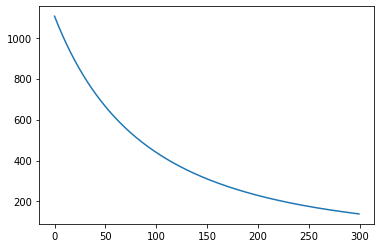

In [ ]:
d = 10
L = 1
batch_sizes = numrows // 100, numcols // 100

torch.manual_seed(42)
P = torch.randn(numrows, d, requires_grad=True)
Q = torch.randn(numcols, d, requires_grad=True)

# огромный lr так как количество параметров = бесконечность
optimizer = torch.optim.SGD([P, Q], lr=0.5)

optimize_loss(Atrain, P, Q,  L, loss, optimizer, batch_sizes, num_epochs=300)

посмотрим на итоговый loss на train, test:

In [ ]:
# # ядро постоянно падает, и вычисление loss на всем массиве занимает 5 мин+, поэтому я тут закомментировал
# # если запустить ячейку, train_loss = 1.4674
# loss(Atrain, P, Q, L)

In [ ]:
# # если запустить ячейку, test_loss = 1.4698
# loss(Atest, P, Q, L)

очевидно что лосс примерно одинаковый, так как Atest почти идентичен Atrain.\
 посчитаем precision@k

In [ ]:
k = 3
AtrainSort = np.argsort(Atrain.toarray(), axis=1)[:,::-1][:,:k]
AtestSort  = np.argsort(Atest.toarray(), axis=1)[:,::-1][:,:k]

Apred = P.detach().numpy()@Q.detach().numpy().T
Apred = np.argsort(Apred, axis=1)[:,::-1][:,:k]

In [ ]:
n_matches_train = sum([np.intersect1d(row_a, row_b).size > 0 for row_a, row_b in zip(Apred, AtrainSort)])
n_matches_test  = sum([np.intersect1d(row_a, row_b).size > 0 for row_a, row_b in zip(Apred, AtestSort)])

n_matches_train, n_matches_test

(4, 5)

все очень плачевно для k=3...

In [ ]:
# тут ядро упало и я не успел посчитать результат :'(
k = 20
AtrainSort = np.argsort(Atrain.toarray(), axis=1)[:,::-1][:,:k]
AtestSort  = np.argsort(Atest.toarray(), axis=1)[:,::-1][:,:k]

Apred = P.detach().numpy()@Q.detach().numpy().T
Apred = np.argsort(Apred, axis=1)[:,::-1][:,:k]

n_matches_train = sum([np.intersect1d(row_a, row_b).size > 0 for row_a, row_b in zip(Apred, AtrainSort)])
n_matches_test  = sum([np.intersect1d(row_a, row_b).size > 0 for row_a, row_b in zip(Apred, AtestSort)])

n_matches_train, n_matches_test

: 

## ADAM

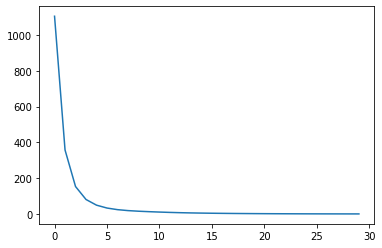

In [17]:
d = 10
L = 1
batch_sizes = numrows // 100, numcols // 100

torch.manual_seed(42)
P = torch.randn(numrows, d, requires_grad=True)
Q = torch.randn(numcols, d, requires_grad=True)

# тут lr=0.5 приводит к расхождению, а при lr=0.05 по графику видно, что уже в зоне оптимальных значений,
# при этом если брать больше, то скорее всего разойдется.
optimizer = torch.optim.Adam([P, Q], lr=0.05)

# количество эпох не нужно брать больше тк лосс функция уже сильно плоская. надо было написать условие остановки
optimize_loss(Atrain, P, Q,  L, loss, optimizer, batch_sizes, num_epochs=30)

In [22]:
loss(Atrain, P, Q, L)

: 

In [18]:
loss(Atest, P, Q, L)

tensor(0.0138, grad_fn=<AddBackward0>)

супер! и без тюнинга гиперпараметров

In [20]:
k = 3
AtrainSort = np.argsort(Atrain.toarray(), axis=1)[:,::-1][:,:k]
AtestSort  = np.argsort(Atest.toarray(), axis=1)[:,::-1][:,:k]

Apred = P.detach().numpy()@Q.detach().numpy().T
Apred = np.argsort(Apred, axis=1)[:,::-1][:,:k]

n_matches_train = sum([np.intersect1d(row_a, row_b).size > 0 for row_a, row_b in zip(Apred, AtrainSort)])
n_matches_test  = sum([np.intersect1d(row_a, row_b).size > 0 for row_a, row_b in zip(Apred, AtestSort)])

n_matches_train, n_matches_test

(16, 23)

Adam сильно лучше сошелся к оптимуму чем SGD. Возможно, для SGD стоило сделать больше эпох, но все еще результат не особо впечатляющий.\
для полной картины нужно взглянуть на график зависимости от k, и нескольких гиперпараметров

In [19]:
# запустите и посмотрите вы! (я это сделаю после дедлайна, а сейчас отправлю в бот эту версию)
k = 20
AtrainSort = np.argsort(Atrain.toarray(), axis=1)[:,::-1][:,:k]
AtestSort  = np.argsort(Atest.toarray(), axis=1)[:,::-1][:,:k]

Apred = P.detach().numpy()@Q.detach().numpy().T
Apred = np.argsort(Apred, axis=1)[:,::-1][:,:k]

n_matches_train = sum([np.intersect1d(row_a, row_b).size > 0 for row_a, row_b in zip(Apred, AtrainSort)])
n_matches_test  = sum([np.intersect1d(row_a, row_b).size > 0 for row_a, row_b in zip(Apred, AtestSort)])

n_matches_train, n_matches_test

(131, 158)

- - -

p.p.s. это все что я успел сделать!(((\
задание интересное, но мой компьютер его явно не вывозит, тк каждая ячейка выполняется ококло 6-10 минут...\
возможно, стоило порезать датасет, но хотелось посмотреть как будут обстоять дела у общей постановки с разреженной матрицей